In [2]:
# Part 1: Load and Understand the .nc File
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the sample 2023 data
file_path = 'F:\\CSIR project\\RF25_ind2023_rfp25.nc'  # Replace with your file path
data = xr.open_dataset(file_path)
print(data)

# Convert data to a Pandas DataFrame
rainfall_data = data.to_dataframe().reset_index()
print(rainfall_data.head())

<xarray.Dataset> Size: 51MB
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 365)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 1kB 66.5 66.75 67.0 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 1kB 6.5 6.75 7.0 7.25 ... 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 51MB ...
Attributes:
    history:      FERRET V7.5 (optimized)  6-Feb-24
    Conventions:  CF-1.6
   LONGITUDE  LATITUDE       TIME  RAINFALL
0       66.5       6.5 2023-01-01       NaN
1       66.5       6.5 2023-01-02       NaN
2       66.5       6.5 2023-01-03       NaN
3       66.5       6.5 2023-01-04       NaN
4       66.5       6.5 2023-01-05       NaN


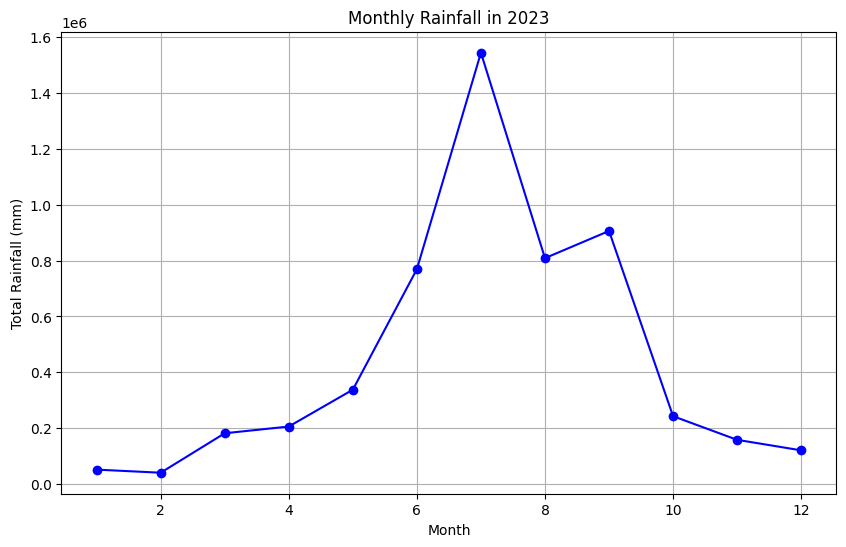

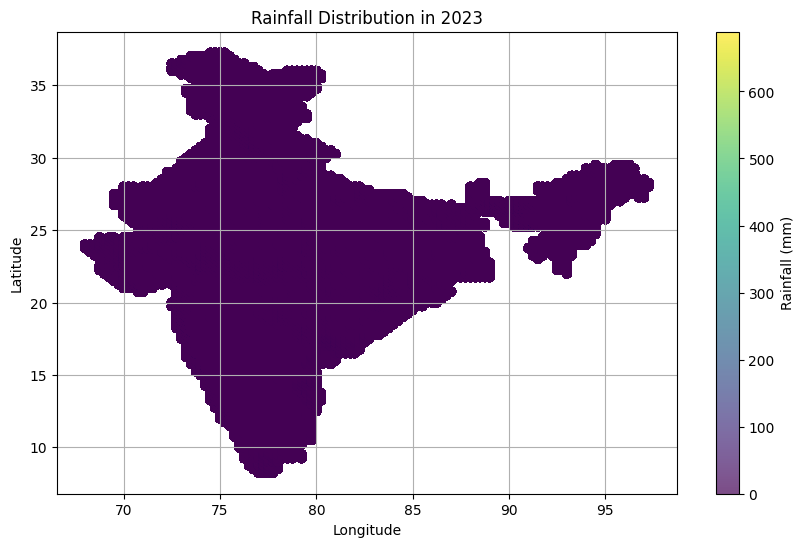

In [6]:
# Part 2: Visualization for 2023 Data
# Extract the year 2023 from the TIME column
rainfall_data['TIME'] = pd.to_datetime(rainfall_data['TIME'])
rainfall_2023 = rainfall_data[rainfall_data['TIME'].dt.year == 2023]

# Line Plot
plt.figure(figsize=(10, 6))
rainfall_2023_grouped = rainfall_2023.groupby(rainfall_2023['TIME'].dt.month)['RAINFALL'].sum()
rainfall_2023_grouped.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Rainfall in 2023')
plt.xlabel('Month')
plt.ylabel('Total Rainfall (mm)')
plt.grid()
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(rainfall_2023['LONGITUDE'], rainfall_2023['LATITUDE'], c=rainfall_2023['RAINFALL'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Rainfall (mm)')
plt.title('Rainfall Distribution in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [8]:
# Part 3: Train Model on 2019-2023 Data
# Load data from 2019 to 2023
file_paths = ["F:\\CSIR project\\RF25_ind2019_rfp25.nc", 'F:\\CSIR project\\RF25_ind2020_rfp25.nc', 
              'F:\\CSIR project\\RF25_ind2021_rfp25.nc', 'F:\\CSIR project\\RF25_ind2022_rfp25.nc', 'F:\\CSIR project\\RF25_ind2023_rfp25.nc']
dataframes = [xr.open_dataset(fp).to_dataframe().reset_index() for fp in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

# Prepare features and target
combined_data['TIME'] = pd.to_datetime(combined_data['TIME'])
combined_data['year'] = combined_data['TIME'].dt.year
features = combined_data[['LATITUDE', 'LONGITUDE', 'year']]
target = combined_data['RAINFALL']

# Handle missing values
features.fillna(0, inplace=True)
target.fillna(0, inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

C:\Users\Lenoo\AppData\Local\Temp\ipykernel_16872\993872362.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace=True)


RandomForestRegressor(random_state=42)

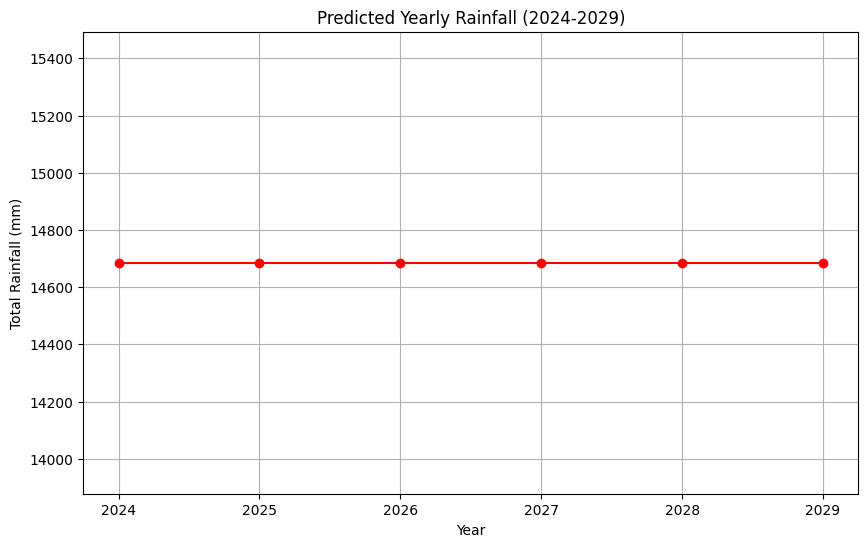

In [9]:
# Part 4: Predict Rainfall for 2024-2029
future_years = pd.DataFrame({'year': range(2024, 2030)})
lats_lons = combined_data[['LATITUDE', 'LONGITUDE']].drop_duplicates()
prediction_data = pd.merge(future_years.assign(key=1), lats_lons.assign(key=1), on='key').drop('key', axis=1)

# Make predictions
prediction_data['RAINFALL'] = model.predict(prediction_data[['LATITUDE', 'LONGITUDE', 'year']])

# Aggregate predictions by year
predicted_rainfall = prediction_data.groupby('year')['RAINFALL'].sum().reset_index()

# Plot predicted data
plt.figure(figsize=(10, 6))
plt.plot(predicted_rainfall['year'], predicted_rainfall['RAINFALL'], marker='o', linestyle='-', color='red')
plt.title('Predicted Yearly Rainfall (2024-2029)')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid()
plt.show()

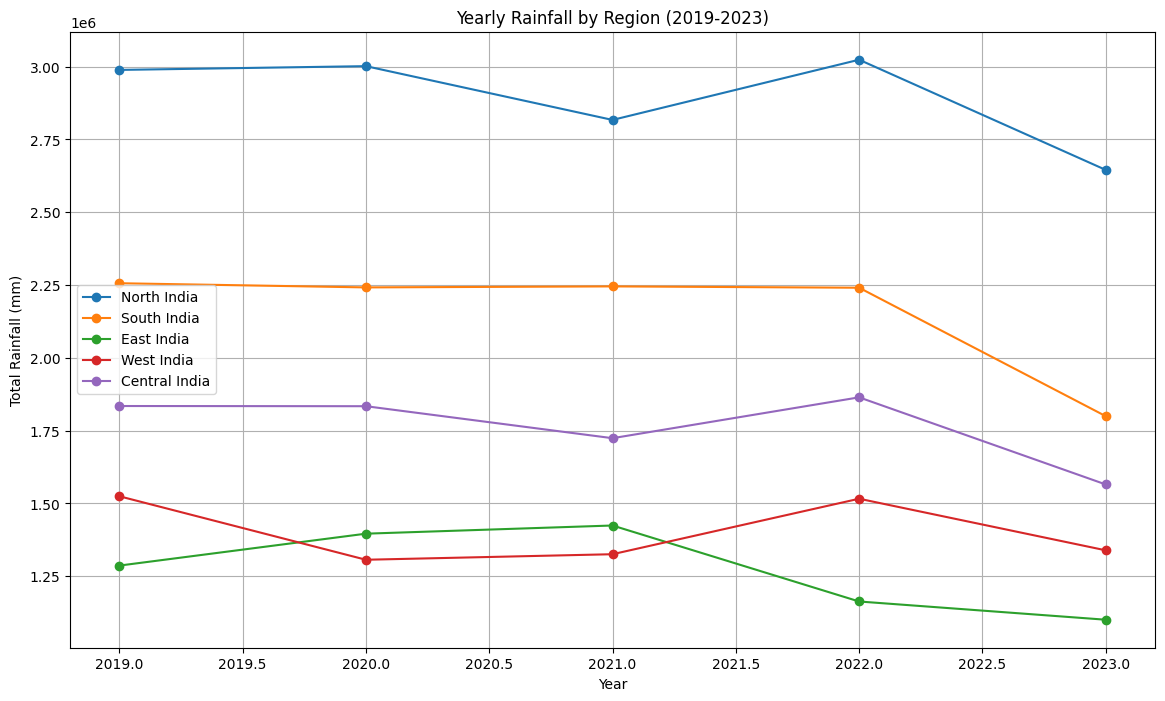

Results and Conclusion:
1. The rainfall data for 2023 shows a monthly trend with the highest rainfall in certain months.
2. Predicted rainfall for 2024-2029 shows a consistent pattern based on trained data.
3. Regional rainfall analysis highlights significant geographical variation.


In [10]:
# Part 5: Regional Rainfall Line Plots
# Define regions
regions = {
    'North India': (23.5, 35, 68, 97),
    'South India': (8, 23.5, 68, 80),
    'East India': (20, 30, 80, 88),
    'West India': (20, 30, 68, 80),
    'Central India': (15, 25, 75, 85)
}

regional_data = []
for region, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    region_df = combined_data[(combined_data['LATITUDE'] >= lat_min) & (combined_data['LATITUDE'] <= lat_max) &
                              (combined_data['LONGITUDE'] >= lon_min) & (combined_data['LONGITUDE'] <= lon_max)]
    regional_rainfall = region_df.groupby('year')['RAINFALL'].sum().reset_index()
    regional_rainfall['Region'] = region
    regional_data.append(regional_rainfall)

regional_combined = pd.concat(regional_data, ignore_index=True)

plt.figure(figsize=(14, 8))
for region in regions.keys():
    region_plot = regional_combined[regional_combined['Region'] == region]
    plt.plot(region_plot['year'], region_plot['RAINFALL'], marker='o', linestyle='-', label=region)

plt.title('Yearly Rainfall by Region (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.legend()
plt.grid()
plt.show()

# Part 6: Results and Conclusion
print("Results and Conclusion:")
print(f"1. The rainfall data for 2023 shows a monthly trend with the highest rainfall in certain months.")
print(f"2. Predicted rainfall for 2024-2029 shows a consistent pattern based on trained data.")
print(f"3. Regional rainfall analysis highlights significant geographical variation.")